# 配對股交易策略
- 提供一種既能避險又盈利的策略，在市場中找兩隻歷史價格走勢有對衝的股票，組成配對股。在平倉、反向建倉時都能賺取收益。

## 選取兩隻股票代號, 高價股:8454, 低價股:2913  貿易百貨業

 ### 富邦媒體8454
- MOMO購物網，為富邦集團旗下子公司，目前為全台最大B to C (Business To Customer)購物網。
### 台灣農林2913
- 台灣農林股份有限公司(簡稱:農林；代碼:2913.TW)前身為「日本三井物產株式會社」，成立於1950年6月15日，在台北海山地區及新竹大溪地地區的番地開拓大規模茶園，並陸續在大豹、大寮、水流東及磺窟等地創設新式紅茶工廠，生產享譽遐邇的「日東紅茶」。主要從事通路代理、茶葉、虛擬通路行銷、進出口、生物科技、內裝工程、農場經營等業務。

In [206]:
!pip install pandas_datareader
!pip install yfinance
!pip install arch

In [207]:
#載入套件

from pandas_datareader import data as web
import datetime as dt
import yfinance  as yf

import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib.font_manager
from matplotlib.font_manager import FontProperties

from arch.unitroot import ADF
import numpy as np
import re
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [281]:
import datetime as dt
import yfinance  as yf
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import re
import statsmodels.api as sm
import movingAverage as ma


from pandas_datareader import data as web
from arch.unitroot import ADF
from statsmodels.tsa.stattools import adfuller
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY,date2num
from mpl_finance import  candlestick_ohlc

from matplotlib.font_manager import FontProperties

In [208]:
# 獲取股票資料
startTime = '2018-01-01'
endTime = '2019-11-01'

df_8454 = web.get_data_yahoo('8454.TW',startTime, endTime)
df_2913 = web.get_data_yahoo('2913.TW',startTime, endTime)

formStart = '2018-01-01' #形成期開始
formEnd = '2018-12-31' #形成期結束

print(len(df_8454)) 
print(len(df_2913)) 

444
444


In [209]:
print(df_8454.head())
print(df_2913.head())

             High    Low   Open  Close    Volume   Adj Close
Date                                                        
2018-01-02  221.0  216.0  216.5  220.0  151200.0  205.361313
2018-01-03  223.0  219.0  221.0  222.0  145210.0  207.228226
2018-01-04  223.5  217.0  223.0  223.5  127499.0  208.628418
2018-01-05  223.5  220.0  223.5  223.0  131066.0  208.161697
2018-01-08  229.0  223.0  224.5  224.0  185375.0  209.095154
             High    Low   Open  Close     Volume  Adj Close
Date                                                        
2018-01-02  15.55  15.40  15.45  15.45  1367846.0  14.725713
2018-01-03  15.60  15.40  15.40  15.50  1058930.0  14.773369
2018-01-04  15.60  15.35  15.55  15.50  1002007.0  14.773369
2018-01-05  15.60  15.45  15.50  15.60   907552.0  14.868682
2018-01-08  15.65  15.45  15.60  15.45  1802342.0  14.725713


# 合併兩支股票

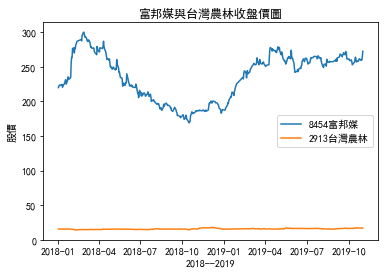

In [210]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

#font = FontProperties(fname=r"c:\windows\fonts\msjh.ttc", size=14, weight='normal', style='normal') # 步驟二

pairf=pd.concat([df_8454.Close,df_2913.Close],axis = 1) 
pairf.columns = ['富邦媒','台灣農林']
len(pairf)


plt.plot(pairf)
plt.xlabel("2018--2019") # 步驟三
plt.ylabel("股價")

plt.legend(labels=['8454富邦媒', '2913台灣農林'],  loc='best')
plt.title("富邦媒與台灣農林收盤價圖")
plt.savefig('8454-2913.png')

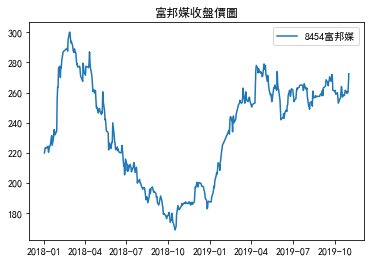

In [211]:
plt.plot(df_8454.Close)
plt.legend(labels=['8454富邦媒'],  loc='best')
plt.title("富邦媒收盤價圖")
plt.savefig('8454富邦媒.png')

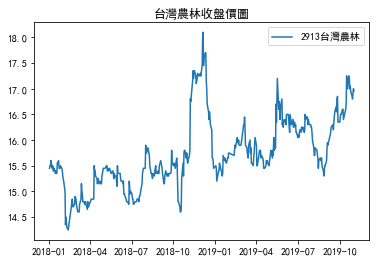

In [190]:
plt.plot(df_2913.Close)
plt.legend(labels=['2913台灣農林'],  loc='best')
plt.title("台灣農林收盤價圖")
plt.savefig('2913台灣農林.png')

In [191]:
#建構標準化價格之差平方累積SSD函數，計算兩隻股票標準化價格的距離
def SSD(priceX,priceY):
    if priceX is None or priceY is None:
        print('缺少價格序列.')
    standardX=priceX/priceX[0]
    standardY=priceY/priceY[0]
    SSD=np.sum((standardX-standardY)**2)
    return(SSD) 

df_8454 = pairf['富邦媒']  
df_2913 = pairf['台灣農林'] 
dis=SSD(df_8454,df_2913)
dis


12.521523296133548

# 一階整合序列
- 要判對兩隻股票是否具有具整合要先檢定對數價格序列是否為一階整合序列，或者檢定是否為定態時間序列
- 使用單根檢定：如果不拒絕Ｈ0，我們檢查的序列可能存在單根，序列為非定態時間序列，如果拒絕Ｈ0，則序列不存在單根，表示即為定態時間序列


## 8454收盤價

In [212]:
#step1：取log對數後
df_8454log=np.log(df_8454.Close) #對6477收盤價取log
# H0:有單根檢定_非定態時序
# H1:是定態時序
adf_8454=ADF(df_8454log)  #驗證 [定態時間序列]
print(adf_8454.summary().as_text())  #不拒絕H0 代表此為非定態時序

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.394
P-value                         0.585
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# 因log(收盤價)不為定態時序, 因此再針對log(收盤價)取一階差分

In [213]:
ret_8454=df_8454log.diff()[1:]  #取對數後, 取一階差分
adfret_8454=ADF(ret_8454)
print(adfret_8454.summary().as_text())  #一階差分為定態時序

   Augmented Dickey-Fuller Results   
Test Statistic                 -4.438
P-value                         0.000
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### 拒絕H0表示富邦媒的對數價格差分（收益率）序列為定態時間序列

## 2913收盤價

In [214]:
#step1：取log對數後
df_2913log=np.log(df_2913.Close) #對6477收盤價取log
# H0:有單根檢定_非定態時序
# H1:是定態時序
adf_2913=ADF(df_2913log)  #驗證 [定態時間序列]
print(adf_2913.summary().as_text())  #不拒絕H0 代表此為非定態時序

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.345
P-value                         0.158
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# 因log(收盤價)不為定態時序, 因此再針對log(收盤價)取一階差分

In [215]:
ret_2913=df_2913log.diff()[1:]  #取對數後, 取一階差分
adfret_2913=ADF(ret_2913)
print(adfret_2913.summary().as_text())  #一階差分為定態時序

   Augmented Dickey-Fuller Results   
Test Statistic                 -7.170
P-value                         0.000
Lags                                7
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## 8454 8429一階差分皆為定態時序
## 表示可進行下一步 [一階共整合建模]

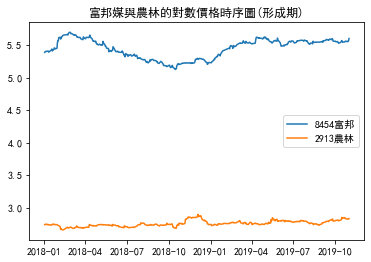

In [216]:
#  兩隻配對股log 時序圖
plt.plot(df_8454log)
plt.plot(df_2913log)
plt.legend(labels=['8454富邦', '2913農林'],  loc='best')
plt.title('富邦媒與農林的對數價格時序圖(形成期)') 
plt.savefig('8454-8429log.png')

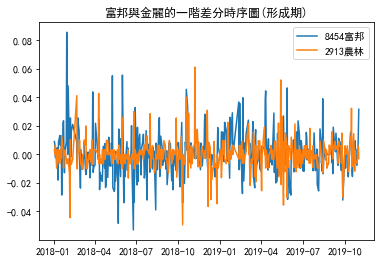

In [217]:
#  兩隻配對股log 一階差分 時序圖
plt.plot(ret_8454)
plt.plot(ret_2913)
plt.legend(labels=['8454富邦', '2913農林'],  loc='best')
plt.title('富邦與金麗的一階差分時序圖(形成期)') 
plt.savefig('8454-2913ret.png')

## 可以看出富邦媒和農林的股票對數價格的差分序列是定態的，整體都在0附近上下波動。

# 單元三 -- 建立共整合模型
### 兩支配對股票(低價股:Y, 高價股:X)
### 對數價格的共整合檢定(一階整合序列)
### 回歸建模 ==> log(Y) = alpha + beta * log(x) + epsilon
### 檢定:殘差hat(epsilon) 是否為定態時序?
### 殘差 = hat(epsilon) = log(Y)-hat(lot(Y))
## 結論：若殘差為定態時序, 則兩支股票(對數價格)有共整合關係

In [218]:
model=sm.OLS(df_2913log,sm.add_constant(df_8454log))  #建模
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1799
Date:                Tue, 12 Nov 2019   Prob (F-statistic):              0.672
Time:                        19:07:04   Log-Likelihood:                 755.65
No. Observations:                 444   AIC:                            -1507.
Df Residuals:                     442   BIC:                            -1499.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7881      0.077     36.035      0.0

/Users/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [219]:
alpha=results.params[0]
alpha

2.7881006246765887

In [220]:
alpha=results.params[0]  #截距項
beta=results.params[1]  #回歸係數
spread=df_2913log-beta*df_8454log-alpha #  計算殘差

In [221]:
spread.head()

Date
2018-01-02   -0.018018
2018-01-03   -0.014732
2018-01-04   -0.014692
2018-01-05   -0.008274
2018-01-08   -0.017909
Name: Close, dtype: float64

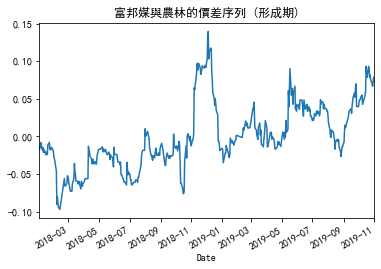

In [222]:
#繪製殘差序列時序圖
spread.plot()
plt.title('富邦媒與農林的價差序列 (形成期)') #回歸殘差
plt.savefig('8454-2913ols.png')

In [223]:
# 針對殘差做ADF檢定
adfSpread=ADF(spread, trend='nc') 
print(adfSpread.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.351
P-value                         0.018
Lags                                8
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# 結論
### 因pvalue = 0.018< 0.05 拒絕H0,故8454 2913之殘差為定態時序，富邦媒與農林的隊數價格序列具有共整合關係。

In [ ]:
###建構PairTrading類別

In [224]:
######PairTrading Class #############

class PairTrading:
    def SSD(self,priceX,priceY):
        if priceX is None or priceY is None:
            print('缺少價格序列.')
        standardX=priceX/priceX[0]
        standardY=priceY/priceY[0]
        SSD=np.sum((standardY-standardX)**2)
        return(SSD)
    def SSDSpread(self,priceX,priceY):
        if priceX is None or priceY is None:
            print('缺少價格序列.')
        standardX=priceX/priceX[0]
        standardY=priceY/priceY[0]
        spread=standardY-standardX
        return(spread)
    def cointegration(self,priceX,priceY):
        if priceX is None or priceY is None:
            print('缺少價格序列.')
        priceX=np.log(priceX)
        priceY=np.log(priceY)
        results=sm.OLS(priceY,sm.add_constant(priceX)).fit()
        resid=results.resid
        adfSpread=ADF(resid)
        if adfSpread.pvalue>=0.05:
            print('''交易價格不具有協整關係.
            P-value of ADF test: %f
            Coefficients of regression:
            Intercept: %f
            Beta: %f
             ''' % (adfSpread.pvalue, results.params[0], results.params[1]))
            return(None)
        else:
            print('''交易價格具有協整關係.
            P-value of ADF test: %f
            Coefficients of regression:
            Intercept: %f
            Beta: %f
             ''' % (adfSpread.pvalue, results.params[0], results.params[1]))
            return(results.params[0], results.params[1])
    def CointegrationSpread(self,priceX,priceY,
                            formStart,formEnd,tradeStart,tradeEnd):
        if priceX is None or priceY is None:
            print('缺少價格序列.')
        formX=priceX[formStart:formEnd]
        formY=priceY[formStart:formEnd]
        tradeX=priceX[tradeStart:tradeEnd]
        tradeY=priceY[tradeStart:tradeEnd]
        coefficients=self.cointegration(formX,formY)
        if coefficients is None:
                print('未形成協整關係,無法配對.')
        else:
            spread=(np.log(tradeY)
            -coefficients[0]-coefficients[1]*np.log(tradeX))
            return(spread)
    def calBound(self,priceX,priceY,method,formStart,formEnd,width=1.5):
        formX=priceX[formStart:formEnd]
        formY=priceY[formStart:formEnd]
        if method=='SSD':
            spread=self.SSDSpread(formX,formY)            
            mu=np.mean(spread)
            sd=np.std(spread)
            UpperBound=mu+width*sd
            LowerBound=mu-width*sd
            return(UpperBound,LowerBound)
        elif method=='Cointegration':
            spread=self.CointegrationSpread(priceX,priceY,formStart,formEnd,
                 formStart,formEnd)
            mu=np.mean(spread)
            sd=np.std(spread)
            UpperBound=mu+width*sd
            LowerBound=mu-width*sd
            return(UpperBound,LowerBound)
        else:
            print('不存在該方法. 請選擇"SSD"或是"Cointegration".')



In [230]:
formStart = '2018-01'
formEnd = '2018-12'
tradeStart = '2019-01'
tradeEnd = '2019-06'
priceA=df_8454.Close
priceB=df_2913.Close
priceAf=priceA[formStart:formEnd]
priceBf=priceB[formStart:formEnd]
priceAt=priceA[tradeStart:tradeEnd]
priceBt=priceB[tradeStart:tradeEnd]

pt=PairTrading()

In [231]:
SSD=pt.SSD(priceAf,priceBf)
SSD

8.79273664170228

In [232]:
SSDspread=pt.SSDSpread(priceAf,priceBf)
SSDspread.describe()
SSDspread.head()

Date
2018-01-02    0.000000
2018-01-03   -0.005855
2018-01-04   -0.012673
2018-01-05   -0.003928
2018-01-08   -0.018182
Name: Close, dtype: float64

In [233]:
coefficients=pt.cointegration(priceAf,priceBf)
coefficients
alpha
beta

交易價格具有協整關係.
            P-value of ADF test: 0.029575
            Coefficients of regression:
            Intercept: 3.510274
            Beta: -0.143408
             


-0.006020776077056651

In [234]:
CoSpreadF=pt.CointegrationSpread(priceA,priceB,
             formStart,formEnd,formStart,formEnd)
CoSpreadF.head()

交易價格具有協整關係.
            P-value of ADF test: 0.029575
            Coefficients of regression:
            Intercept: 3.510274
            Beta: -0.143408
             


Date
2018-01-02    0.000826
2018-01-03    0.005355
2018-01-04    0.006321
2018-01-05    0.012430
2018-01-08    0.003410
Name: Close, dtype: float64

In [235]:
CoSpreadTr=pt.CointegrationSpread(priceA,priceB,formStart,formEnd,
            tradeStart,tradeEnd)
CoSpreadTr.describe()

交易價格具有協整關係.
            P-value of ADF test: 0.029575
            Coefficients of regression:
            Intercept: 3.510274
            Beta: -0.143408
             


count    115.000000
mean       0.046990
std        0.032958
min       -0.036135
25%        0.032304
50%        0.046209
75%        0.073999
max        0.129580
Name: Close, dtype: float64

In [236]:
bound=pt.calBound(priceA,priceB,'Cointegration',
      formStart,formEnd,width=1.2)
bound

交易價格具有協整關係.
            P-value of ADF test: 0.029575
            Coefficients of regression:
            Intercept: 3.510274
            Beta: -0.143408
             


(0.04978240441530432, -0.049782404415289486)

## Python實測配對交易策略

In [237]:
mu=np.mean(CoSpreadF)
sd=np.std(CoSpreadF)

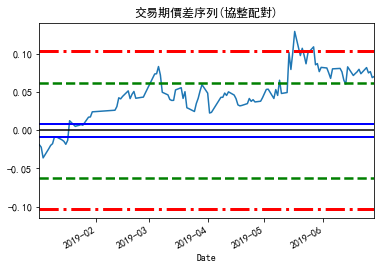

In [238]:
#繪製價差區間圖
#設定交易期
CoSpreadTr.plot()
plt.title('交易期價差序列(協整配對)')
plt.axhline(y=mu,color='black')
plt.axhline(y=mu+0.2*sd,color='blue',ls='-',lw=2)
plt.axhline(y=mu-0.2*sd,color='blue',ls='-',lw=2)
plt.axhline(y=mu+1.5*sd,color='green',ls='--',lw=2.5)
plt.axhline(y=mu-1.5*sd,color='green',ls='--',lw=2.5)
plt.axhline(y=mu+2.5*sd,color='red',ls='-.',lw=3) 
plt.axhline(y=mu-2.5*sd,color='red',ls='-.',lw=3) 

### 設定u±1.5sd和u±0.2sd為開倉與平倉的臨界值，將u±2.5sd 破裂強制平倉的臨界值
- 當價差上穿u+1.5sd時，做空配對股票，反向建倉（賣出低價股買入高價股，股票資金比值為beta）
- 當價差上穿u+0.2sd時，做多配對股票，反向平倉（買入低價股，賣出高價股）
- 當價差下穿u-1.5sd時，做多配對股票，正向建倉（買入低價股，賣出高價股）
- 當價差回復到u-0.2sd時，做空配對股，正向平倉
- 當價差突破u±2.5sd時，即時平倉

做空：賣出
做多：買入
建倉：交易者新買入或新賣出一定數量的期貨合約
平倉：買回已賣出合約，或賣出己買入合約的行為。

## 布林通道

In [245]:
#BBands 
#定義布林帶通道函數
def bbands(tsPrice,period=20,times=2):
    upBBand=pd.Series(0.0,index=tsPrice.index)
    midBBand=pd.Series(0.0,index=tsPrice.index)
    downBBand=pd.Series(0.0,index=tsPrice.index)
    sigma=pd.Series(0.0,index=tsPrice.index)
    for i in range(period-1,len(tsPrice)):
        midBBand[i]=np.nanmean(tsPrice[i-(period-1):(i+1)])
        sigma[i]=np.nanstd(tsPrice[i-(period-1):(i+1)])
        upBBand[i]=midBBand[i]+times*sigma[i]
        downBBand[i]=midBBand[i]-times*sigma[i]
    BBands=pd.DataFrame({'upBBand':upBBand[(period-1):],\
                         'midBBand':midBBand[(period-1):],\
                         'downBBand':downBBand[(period-1):],\
                         'sigma':sigma[(period-1):]})
    return(BBands)


In [246]:
### 8454富邦媒
Close1=df_8454.Close
df_8454BBands=bbands(Close1,20,2)
df_8454BBands.head()

,upBBand,midBBand,downBBand,sigma
Date,,,,
2018-01-29,236.941748,227.100,217.258252,4.920874
2018-01-30,244.220602,228.875,213.529398,7.672801
2018-01-31,252.129943,230.950,209.770057,10.589972
2018-02-01,258.117241,232.950,207.782759,12.583620
2018-02-02,266.677979,235.625,204.572021,15.526489


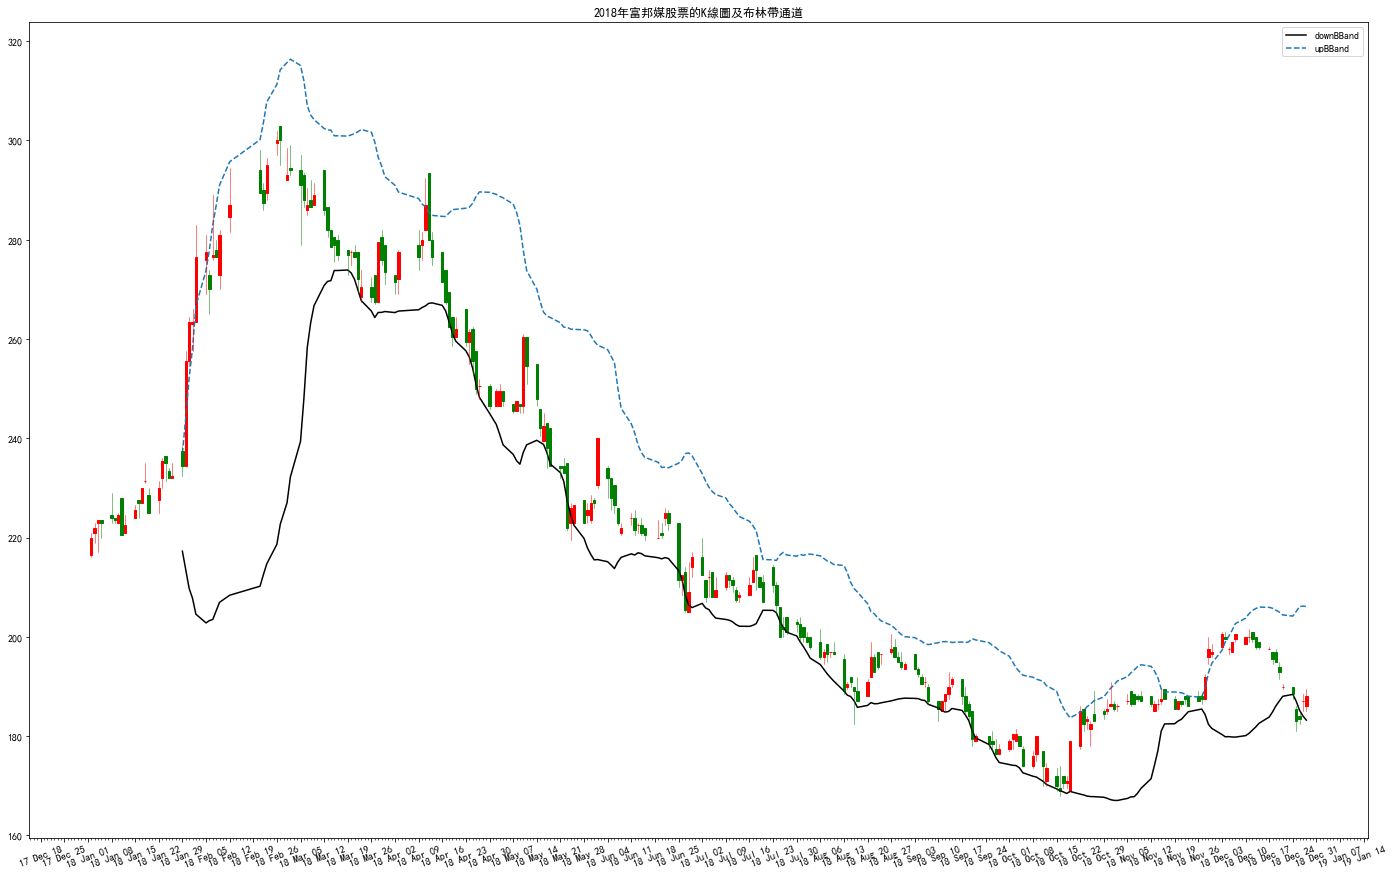

In [249]:
#繪製2018年布林帶上下通道線
%matplotlib inline
fig = plt.figure(figsize=(24,15))
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import candle
candle.candleLinePlots(candleData=df_8454[:'2018-12-31'],
        candleTitle='2018年富邦媒股票的K線圖及布林帶通道',
        splitFigures=False,
        Data=df_8454BBands[:'2018-12-31'][['downBBand','upBBand']])

In [250]:
#建造布林帶風險函數
def CalBollRisk(tsPrice,k,multiplier):
    n=len(tsPrice)
    m=len(multiplier)
    tsPrice=tsPrice[k:]
    BollRisk=[]
    for i in range(m):
        BBands=bbands(tsPrice,k,multiplier[i])
        a=0
        b=0
        for j in range(len(BBands)):            
            if tsPrice[j]>BBands.upBBand[j]:
                a+=1
            elif tsPrice[j]<BBands.downBBand[j]:
                b+=1
        BollRisk.append(100*(a+b)/n)
    return(BollRisk)

In [251]:
#計算富邦媒不同年份的布林帶風險
multiplier=[1,1.65,1.96,2,2.58]

price2018=Close1['2018']
CalBollRisk(price2015,20,multiplier)

[51.42857142857143,
 23.26530612244898,
 13.877551020408163,
 12.244897959183673,
 2.857142857142857]

In [252]:
#2019
CalBollRisk(Close1['2019'],20,multiplier)

[28.448275862068964,
 16.379310344827587,
 12.931034482758621,
 11.206896551724139,
 4.310344827586207]

### 通道突破交易策略制定

In [254]:
#python捕捉唐奇安通道突破
#先定義向上突破函數和向下含數

def upbreak(tsLine,tsRefLine):
    n=min(len(tsLine),len(tsRefLine))
    tsLine=tsLine[-n:]
    tsRefLine=tsRefLine[-n:]
    signal=pd.Series(0,index=tsLine.index)
    for i in range(1,len(tsLine)):
        if all([tsLine[i]>tsRefLine[i],tsLine[i-1]<tsRefLine[i-1]]):
            signal[i]=1
    return(signal)
def downbreak(tsLine,tsRefLine):
    n=min(len(tsLine),len(tsRefLine))
    tsLine=tsLine[-n:]
    tsRefLine=tsRefLine[-n:]
    signal=pd.Series(0,index=tsLine.index)
    for i in range(1,len(tsLine)):
        if all([tsLine[i]<tsRefLine[i],tsLine[i-1]>tsRefLine[i-1]]):
            signal[i]=1
    return(signal)

In [255]:
#strategy 1
#布林帶上下通道突破策略
BBands=bbands(Close1,20,2)

upbreakBB1=upbreak(Close1,BBands.upBBand)
downbreakBB1=downbreak(Close1,BBands.downBBand)
#信號出現2大後進行交易
upBBSig1=-upbreakBB1.shift(2)
downBBSig1=downbreakBB1.shift(2)

tradSignal1=upBBSig1+downBBSig1
tradSignal1[tradSignal1==-0]=0
#進行交易平價前，先購造交易平價函數perform()
def perform(tsPrice,tsTradSig):
    ret=tsPrice/tsPrice.shift(1)-1
    tradRet=(ret*tsTradSig).dropna()
    ret=ret[-len(tradRet):]
    winRate=[len(ret[ret>0])/len(ret[ret!=0]),\
             len(tradRet[tradRet>0])/len(tradRet[tradRet!=0])]
    meanWin=[np.mean(ret[ret>0]),\
             np.mean(tradRet[tradRet>0])]
    meanLoss=[np.mean(ret[ret<0]),\
             np.mean(tradRet[tradRet<0])]
    Performance=pd.DataFrame({'winRate':winRate,'meanWin':meanWin,\
                             'meanLoss':meanLoss})
    Performance.index=['Stock','Trade']
    return(Performance)

In [256]:
#運用績效表現函數perform()來計算布林帶交易的績效表現以及股票本身的績效表現
Performance8454= perform(Close1,tradSignal1)
Performance8454

##第一行為布林帶交易策略的績效表現
##第二行為股票本身的績效表現

,winRate,meanWin,meanLoss
Stock,0.484472,0.013103,-0.011904
Trade,0.590909,0.010440,-0.014478


In [257]:
Close2=df_2913.Close
df_2913BBands=bbands(Close2,20,2)
df_2913BBands.head()

,upBBand,midBBand,downBBand,sigma
Date,,,,
2018-01-29,15.599890,15.4575,15.315110,0.071195
2018-01-30,15.599568,15.4550,15.310432,0.072284
2018-01-31,15.602797,15.4450,15.287203,0.078899
2018-02-01,15.609347,15.4325,15.255653,0.088424
2018-02-02,15.599248,15.4125,15.225751,0.093374


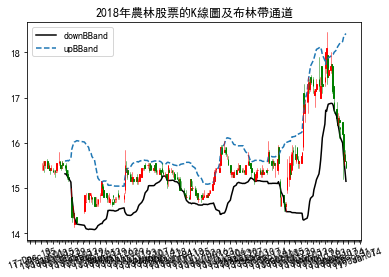

In [274]:
#繪製金麗2015年布林帶上下通道線
%matplotlib inline
#fig = plt.figure(figsize=(24,10))
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import candle
candle.candleLinePlots(candleData=df_2913[:'2018-12-31'],
        candleTitle='2018年農林股票的K線圖及布林帶通道',
        splitFigures=False,
        Data=df_2913BBands[:'2018-12-31'][['downBBand','upBBand']])

In [264]:
#計算金麗不同年份的布林帶風險
multiplier=[1,1.65,1.96,2,2.58]

price2018=Close2['2018']
CalBollRisk(price2015,20,multiplier)

[39.183673469387756,
 18.775510204081634,
 8.979591836734693,
 8.979591836734693,
 2.4489795918367347]

In [265]:
#運用績效表現函數perform()來計算布林帶交易的績效表現以及股票本身的績效表現
Performance2913= perform(Close2,tradSignal1)
Performance2913

##第一行為布林帶交易策略的績效表現
##第二行為股票本身的績效表現

,winRate,meanWin,meanLoss
Stock,0.500000,0.009207,-0.008297
Trade,0.478261,0.005551,-0.006747


## MACD異同移動平均線
### MACD指標可以反映出股票近期的價格走勢的能量和變化強度，透過分析快慢速線和柱狀圖來把握股票的買入和賣出點

In [282]:
def MACD(start,end,df_close,title):
    Close = df_close
    #MACD
    DIF=ma.ewmaCal(Close,12,2/(1+12))\
           -ma.ewmaCal(Close,26,2/(1+26))
    DIF.tail(n=3)

    DEA=ma.ewmaCal(DIF.dropna(),9,2/(1+9))
    DEA.tail()

    MACD=DIF-DEA
    MACD.tail(n=3)

    macddata=pd.DataFrame()
    macddata['DIF']= DIF[start:end]
    macddata['DEA']= DEA[start:end]
    macddata['MACD']= MACD[start:end]
    
    fig = plt.figure(figsize=(18,2))
    #plt.subplot(211)
    plt.plot(DIF[start:end],\
          label="DIF",color='k')
    plt.plot(DEA[start:end], label="DEA",\
            color='b',linestyle='dashed')
    plt.title('信號線DIF与DEA')
    #plt.legend()
    #plt.subplot(212)
    plt.bar(MACD[start:end].index,\
            height=MACD[start:end],\
            label='MACD',color='r')
    plt.title(title)
    plt.legend()  

In [294]:
startTime = '2018-01-01'
endTime = '2019-11-01'
df_8454 = web.get_data_yahoo('8454.TW',startTime, endTime) #高價股 
df_2913 = web.get_data_yahoo('2913.TW',startTime, endTime) #低價股  

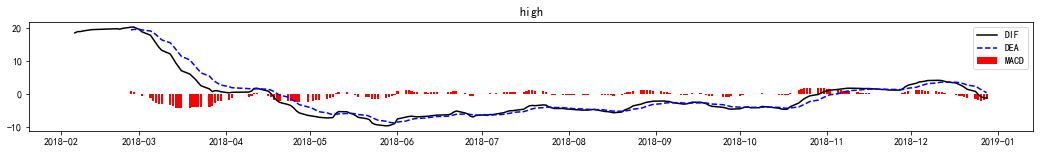

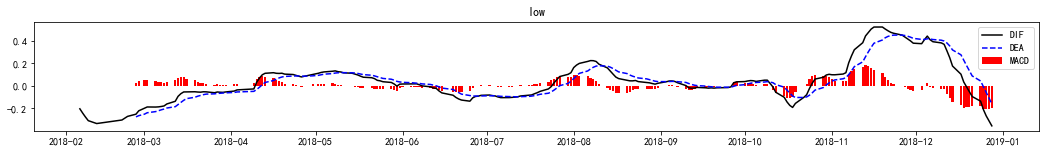

In [295]:
MACD('2018-01','2018-12',df_8454.Close,'high') # 4976
MACD('2018-01','2018-12',df_2913.Close,'low') # 8215

- 當DIF和DEA都在0上方時，表示為多頭行情，當DIF和DEA都在0下方時，表示為空頭行情
- 當DIF上穿DEA線，說明股票價格上升，市場處於上漲行情，釋出賣出信號
- 當DIF下穿DEA線，說明股票價格下跌，市場處於下跌行情，釋出買入信號

柱狀圖表示DIF和DEA的差值，當柱狀圖在0線上方，DIF>DEA，市場走勢強
- 當DIF和DEA均為正，DIF向上突破DEA線，買入信號
- 當DIF和DEA均為負，DIF向下突破DEA線，賣出信號

## RSI相對強弱指標
### 可以透過RSI的值來判斷買入和賣出的情況，進而預測未來股票的價格走勢

In [296]:
def rsi(price,period=6,period_1=24,xlabel='stock'):
    closeDif=(price-price.shift(1)).dropna() # 將第一個值變為NA & 刪除有NA的資料筆
    upPrc=pd.Series(0,index=closeDif.index)  # 以日期為index, 數值為0的資料集 
    upPrc[closeDif>0]=closeDif[closeDif>0]   # 將 > 0 的數值放入
    downPrc=pd.Series(0,index=closeDif.index)
    downPrc[closeDif<0]=-closeDif[closeDif<0]
    rsi=[]
    for i in range(period,len(upPrc)+1):
        up_mean = np.mean(upPrc.values[(i-period):i],\
        dtype=np.float32)  # up 六天平均值
        
        up_down = np.mean(downPrc.values[(i-period):i],\
        dtype=np.float32)  # down 六天平均值
        
        rsi.append(100*up_mean/(up_mean+up_down)) # rsi6 = (100*up) / (up+down) 
    rsi=pd.Series(rsi,index=closeDif.index[(period-1):])
    fig = plt.figure(figsize=(18,2))
    plt.plot(rsi)
    plt.title('RSI6的超買線和超賣線')
    plt.xlabel(xlabel)
    plt.ylim(-10,110)
    plt.axhline(y=80,color='red')
    plt.axhline(y=20,color='red')
    plt.show()
    
    closeDif_1=(price-price.shift(1)).dropna() # 將第一個值變為NA & 刪除有NA的資料筆
    upPrc_1=pd.Series(0,index=closeDif_1.index)  # 以日期為index, 數值為0的資料集 ??
    upPrc_1[closeDif_1>0]=closeDif_1[closeDif_1>0]   # 將 > 0 的數值放入
    downPrc_1=pd.Series(0,index=closeDif_1.index)
    downPrc_1[closeDif_1<0]=-closeDif_1[closeDif_1<0]
    rsi_1=[]
    for i in range(period_1,len(upPrc_1)+1):
        up_mean_1 = np.mean(upPrc_1.values[(i-period_1):i],\
        dtype=np.float32)  # up 六天平均值
        
        up_down_1 = np.mean(downPrc_1.values[(i-period_1):i],\
        dtype=np.float32)  # down 六天平均值
        
        rsi_1.append(100*up_mean_1/(up_mean_1+up_down_1)) # rsi6 = (100*up) / (up+down) 
    rsi_1=pd.Series(rsi_1,index=closeDif_1.index[(period_1-1):])
    
    fig = plt.figure(figsize=(18,2))
    plt.plot(rsi,label='Rsi6')
    plt.plot(rsi_1,
             label='Rsi24',color='red',\
             linestyle='dashed')
    plt.title('RSI黃金交叉和死亡交叉')
    plt.xlabel(xlabel)
    plt.ylim(-10,110)
    plt.legend()
    plt.show()

- RSI值

當RSI值大於80時，股票出現超買信號，買入的力道過大，未來可能會減小，所以股票未來價格可能會下跌，此時賣出股票，等到下跌後再買入股票賺取價差。

當RSI值小於20時，股票出現超賣信號，賣出的力道過大，所以股票未來價格可能會上漲，此時可以買入股票，等到未來價格上漲後再賣出。

- 黃金交叉、死亡交叉

當短期RSI線向上穿越長期RSI線，股票近期買入的力道強，價格上漲的力道大，會釋出一個買入信號，稱為黃金交叉

當短期RSI線向下跌破長期RSI線，股票近期賣出的力道強，價格下跌的力道大，會釋出一個賣出信號，稱為死亡交叉

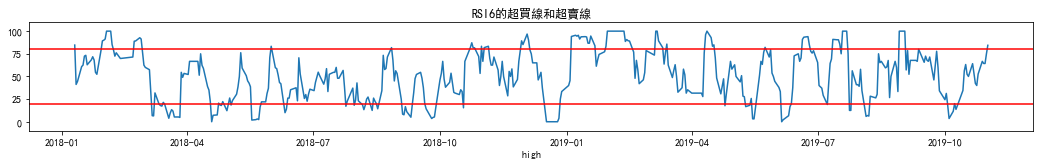

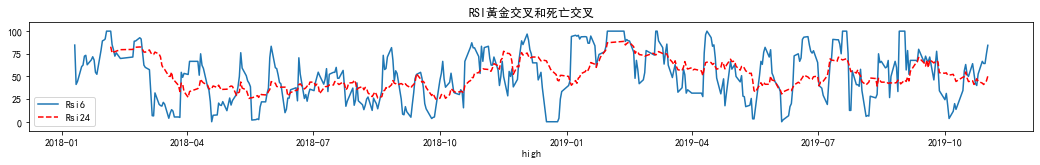

In [298]:
#RSI 6日均線 & 24日均線 &交叉
rsi(df_8454.Close,period=6,period_1=24,xlabel='high')

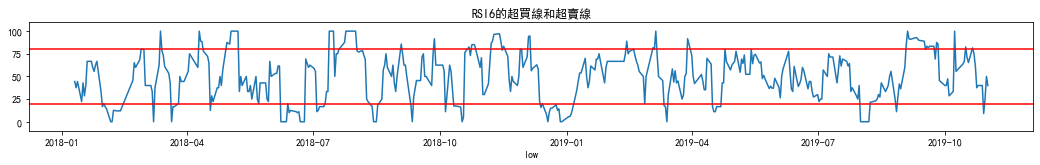

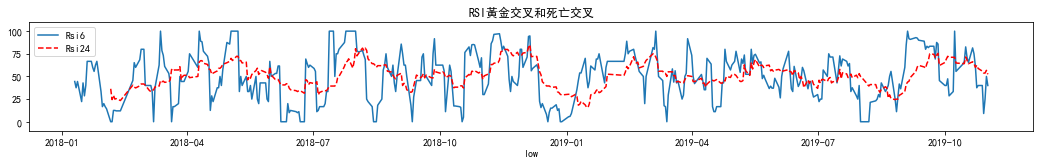

In [299]:
rsi(df_2913.Close,period=6,period_1=24,xlabel='low')

## KDJ隨機指標
一種用於解析市場超買或超賣現象的指標

In [304]:
Close=df_8454.Close
High=df_8454.High
Low=df_8454.Low
ndate=len(Close)
# 計算9天未成熟隨機指標 RSV 的值
RSV=[]
for j in range(8,ndate):
    periodHigh=np.max(High[(j-8):(j+1)])
    periodLow=np.min(Low[(j-8):(j+1)])
    RSV.append(100*(Close[j]-periodLow)\
           /(periodHigh-periodLow))

RSV=pd.Series(RSV,index=Close.index[8:])
RSV.name='RSV'
RSV.head()

Date
2018-01-12     50.000000
2018-01-15     70.833333
2018-01-16     83.333333
2018-01-17    100.000000
2018-01-18     75.862069
Name: RSV, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12e0646a0>,
      dtype=object)

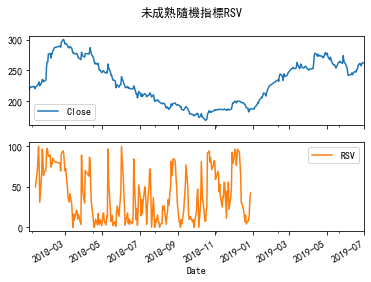

In [305]:
lose1=Close['2018']
RSV1=RSV['2018']
Cl_RSV=pd.DataFrame([Close1,RSV1]).transpose()
Cl_RSV.plot(subplots=True,
             title='未成熟隨機指標RSV')

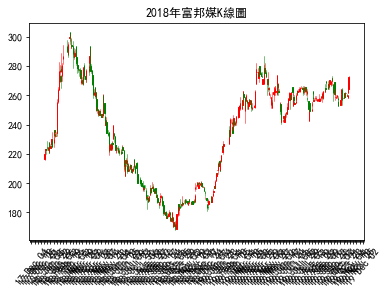

In [306]:
df_84542015=df_8454['2018']
import candle
candle.candlePlot(df_8454,\
                '2018年富邦媒K線圖')

當收盤價等於9日最高價時，RSV取值為100，可以看出綠色蠟燭圖較短或者幾乎沒有，收盤價可能為9天內最低價，若當期收盤價接近9天最低價，可推知當期RSV的值接近0

No handles with labels found to put in legend.


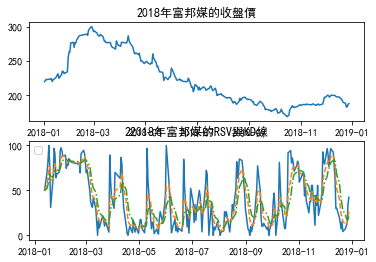

In [307]:
K=[50]
D=[50]

for i in range(len(RSV)):
    KValue = (2/3)*K[-1] + (RSV[i]/3)
    DValue = (2/3)*D[-1] + KValue/3
    K.append(KValue)
    D.append(DValue)

K=pd.Series(K[1:],index=RSV.index)
K.name='KValue'
K.head()

D=pd.Series(D[1:],index=RSV.index)
D.name='DValue'
D.head()
plt.subplot(211)
plt.title('2018年富邦媒的收盤價')
plt.plot(Close['2018'])
plt.subplot(212)
plt.title('2018年富邦媒的RSV與KD線')
plt.plot(RSV['2018'])
plt.plot(K['2018'],linestyle='dashed')
plt.plot(D['2018'],linestyle='-.')
plt.legend(loc='upper left')

K值：由RSV透過指數移動平均EMA得到
D值：K值的指數移動平均EMA得到

J值是ＫＤ指標的輔助指標，近一步反應K與D的乖離程度

In [312]:
J=3*K-2*D
J.name='JValue'
J.head()

Date
2018-01-12     50.000000
2018-01-15     66.203704
2018-01-16     83.641975
2018-01-17    104.320988
2018-01-18     94.257604
Name: JValue, dtype: float64

No handles with labels found to put in legend.


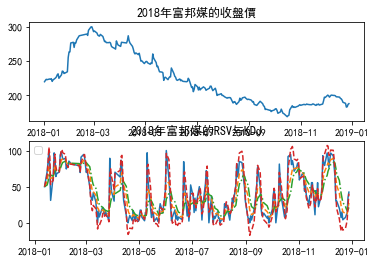

In [314]:
plt.subplot(211)
plt.title('2018年富邦媒的收盤價')
plt.plot(Close['2018'])
plt.subplot(212)
plt.title('2018年富邦媒的RSV与KDJ')
plt.plot(RSV['2018'])
plt.plot(K['2018'],linestyle='dashed')
plt.plot(D['2018'],linestyle='-.')
plt.plot(J['2018'],linestyle='--')
plt.legend(loc='upper left') 

可以看出4種指標走勢大致相同，RSV波動幅度比較大，K與D相似，J值波動幅度相對較為略大

No handles with labels found to put in legend.


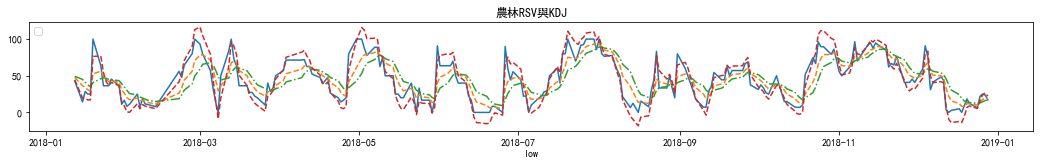

In [318]:
def KDJ(df,start,end,xlabel):
    Close=df.Close
    High=df.High
    Low=df.Low
    ndate=len(Close)
    # 計算9天未成熟隨機指標 RSV 的值
    RSV=[]
    for j in range(8,ndate):
        periodHigh=np.max(High[(j-8):(j+1)])
        periodLow=np.min(Low[(j-8):(j+1)])
        RSV.append(100*(Close[j]-periodLow)\
               /(periodHigh-periodLow))

    RSV=pd.Series(RSV,index=Close.index[8:])
    RSV.name='RSV'
    # 計算 K D 值
    K=[50]
    D=[50]

    for i in range(len(RSV)):
        KValue = (2/3)*K[-1] + (RSV[i]/3)
        DValue = (2/3)*D[-1] + KValue/3
        K.append(KValue)
        D.append(DValue)
        
    K=pd.Series(K[1:],index=RSV.index)
    K.name='KValue'
    D=pd.Series(D[1:],index=RSV.index)
    D.name='DValue'
    J=3*K-2*D
    J.name='JValue'
    fig = plt.figure(figsize=(18,2))
    plt.title('農林RSV與KDJ')
    plt.xlabel(xlabel)
    plt.plot(RSV[start:end])
    plt.plot(K[start:end],linestyle='dashed')
    plt.plot(D[start:end],linestyle='-.')
    plt.plot(J[start:end],linestyle='--')
    plt.legend(loc='upper left') 
    
KDJ(df_2913,formStart,formEnd,xlabel='low')

在KDJ指標中，當K值與D值落在80以上時，為超買區，反之為超賣區。
當J值大於100時，可以視為超買區，反之小於0為超賣區。
- 當K線上穿D線時，為黃金交叉，釋出買入訊號，反之K線下穿D線時，出現死亡交叉，釋出賣出訊號